# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Project Name
Project mentor: Guanghui Qin

Aidan Aug  <aaug1@jh.edu>, Alan Zhang  <azhang42@jh.edu>, Shreya Wadhwa  <swadhwa5@jh.edu>, Trisha Karani <tkarani1@jh.edu>

Github Repository with all the code and datasets: https://github.com/swadhwa5/MLfinalproject
<br>
The .ipynb version of this notebook can also be found in the Gtihub Repo by the name Final_Project_Submission.ipynb

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. Identify potential themes/ image features common among misclassifications in our model
2. Create a majority vote classifier with multiple model types and parameters
3. Augment our model by including a broader dataset with sign-language words for model training instead of just letters and digits: We found that it would be wise to first implement a high performance model just on ASL letters before extending to words and digits.


### Completed Deliverables
1. Model with classification accuracy of 50%: We achieved a much higher accuracy with our models, especially when features were added
2. Model with classification accuracy of 80%: We achieved a much higher accuracy with our models, especially when features were added
3. Identify 5 important data augmentation methods in sign-language classification: We applied various transformations to our images such as Normalize, Reshape, Blur, Vertical Flip, Translation, Scale, and Rotation, examples of which are shown in the Pre-Processing section. 
4. Identity transformations on our data that would not retain accuracy: We identified that testing on our Mult_Augment images, which have more than 1 augmentation on each image decreased the accuracy of our model significantly
5. Create and compare at least two models with differing feature extraction techniques or network architectures: We implemented both LeNet and AlexNet models


### Additional Deliverables
N.A.

# Preliminaries

## What problem were you trying to solve or understand?

#### What are the real-world implications of this data and task?

The ability to communicate using ASL can increase awareness about the hard of hearing community. We want to explore the area of sign language translation: how people who might not be immediately fluent with ASL can communicate with people who rely on sign language. We aim to build a model that can return the alphabet corresponding to the hand gesture as seen in any image. Thus, the input to our algorithm will be images of hand configurations of ASL letters.

Thus, this model can act as a translator for a person who des not know ASL but wishes to talk to a person who only knows ASL. If we are able to achieve good results for ASL, this can be extended to other lesser known sign languages as well, and can motivate people to not only build better models for sign languages but also work towards building good quality datasets for the same.  

#### How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?

This is a supervised classification problem, which is similar to HW3 where we were given fruit images with labels and we were supposed to build different models to classify each fruit image to it's correct label.

#### What makes this problem unique?

There has been a lot of discussion about being more inclusive towards the hard of hearing community by encouraging more people to learn ASL, but few about how we can make use to ML to facilitate the ability to do the same without having to learn the ASL in its entirety.

#### What ethical implications does this problem have?

There are no significant ethical implications to this problem, but in the future we would like to add hand images with different complexities to remove any bias on the bases of race. 


## Dataset(s)

#### Describe the dataset(s) you used. How were they collected?

The dataset images were taken by a team from Massey University. The images are solely hands making a ASL sign with a black background. The images range in size from 200-500 pixels per side. 

The link for the dataset can be found here: https://www.massey.ac.nz/~albarcza/gesture_dataset2012.html

#### Why did you choose them?

We chose this dataset because the dataset is balanced (25 images per letter) and the images are very clear and well structured with a black background. 

#### How many examples in each?

We used a 650 image subset of the dataset, with 25 images per letter (total 26 letters), corresponding to 650 images in total.

In [4]:
from os import listdir
import imghdr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

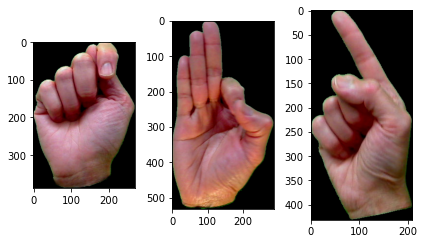

In [5]:
# Load your data and print 2-3 examples
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

path = "./handgesturedataset_part1/"
imgs, labels = loadImages(path)

indices = (np.random.rand(3) * 650).astype(int)

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs[indices[i]])
plt.tight_layout()


## Pre-processing

#### What features did you use or choose not to use? Why?

In addition to the image feature, we used 4 additional features: The coordinates of the convex hull, coordinates of the alphashape, ratio of the two, and finally the ratio of hand to background. We hoped that these features would lend themselves to discovering how many fingers are help up. For example, a closed fist is more convex, and occupies less area compared to a hand that has a few fingers out.

#### If you have categorical labels, were your datasets class-balanced?

Yes, our dataset was balanced, with 25 images per label.

#### How did you deal with missing data? What about outliers?

There was no missing data or outliers

#### What approach(es) did you use to pre-process your data? Why?

We chose to resize the data into 32x32 squares and we also normalized the images. Doing these made it easier to feed into our neural net. Additionally, they made it easier to apply our data augmentations.

#### Are your features continuous or categorical? How do you treat these features differently?

The ratios are continuous, while the coordinates are categorical. We did not do anything different.

In [ ]:
import torchvision
import torchvision.transforms as transforms
import cv2
import alphashape
from descartes import PolygonPatch

convexity for image 1 is 0.9754500818330606
convexity for image 2 is 0.9244992295839753
convexity for image 3 is 0.9784366576819407


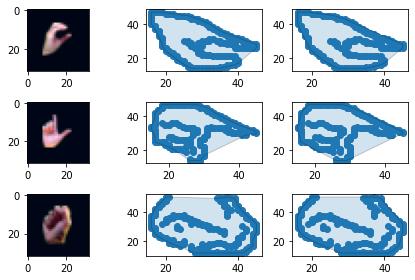

In [ ]:
# For those same examples above, what do they look like after being pre-processed?
def applyTransforms(imgs, crop_size, resize):
    # Define the necessary preprocessing transforms
    num_imgs = len(imgs)
    preprocess = transforms.Compose([
        transforms.Resize(resize),  # Hyperparameter
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
    ])

    # Create tensor array
    transforms_array = np.zeros((num_imgs, 3, crop_size, crop_size))
    for i in range(num_imgs):
        temp = preprocess(imgs[i])
        transforms_array[i, :, :, :] = temp

    return transforms_array
transforms_array = applyTransforms(imgs, crop_size=32, resize=15)

for i in range(3):
    cur = transforms_array[indices[i]]
    out = np.empty((32, 32, 3))
    for z, a in enumerate(cur):
        for j, b in enumerate(a):
            for k, c in enumerate(b):
                out[j][k][z] = c
    orig = cv2.normalize(out, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    plt.subplot(3, 3, 1 + i * 3)
    plt.imshow(orig)
    
    orig = cv2.resize(orig, (64, 64), interpolation = cv2.INTER_AREA)

    edges = cv2.Canny(orig,250,300)

    contours, _ = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    contours = np.concatenate(contours)
    contours = contours.reshape((contours.shape[0], contours.shape[2]))

    alpha = alphashape.alphashape(contours, .07)
    x, y = alpha.exterior.coords.xy
    alphaPoints = np.column_stack((x, y)) # Feature

    convex = alphashape.alphashape(contours, 0.)
    x, y = convex.exterior.coords.xy
    convexPoints = np.column_stack((x, y)) # Feature
    
    ax = plt.subplot(3, 3, 2 + i * 3)
    ax.scatter(*zip(*contours))
    ax.add_patch(PolygonPatch(alpha, alpha=0.2))

    ax = plt.subplot(3, 3, 3 + i * 3)
    ax.scatter(*zip(*contours))
    ax.add_patch(PolygonPatch(convex, alpha=0.2))
    print('convexity for image', i + 1, 'is', alpha.area / convex.area) # Feature
plt.tight_layout()


Above is a demonstration of 3 of the features that we used, the ratio of the alpha shape to the convex hull, coordinates of the convex hull, and coordinates of the alpha shape. The ratio is simply the ratio of the area in blue in the 2 images. The coordinates of the alpha shape and convex hull are the unique points that define the blue regions. IN the above demonstration, the blue dots are the edges that were detected. They were not directly added as a feature to our models. 

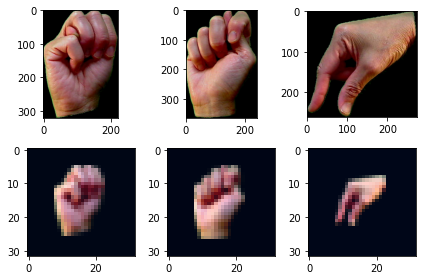

In [10]:
import torchvision.transforms as transforms
import cv2

path = "./handgesturedataset_part1/"
imgs, labels = loadImages(path)

indices = (np.random.rand(3) * 650).astype(int)
def applyTransforms(imgs, crop_size, resize):
    """Applies crop and resizing images to each input image

    Args:
        imgs (list): The list of images from a specified dataset
        resize (int): An integer representing how to first scale the image prior to
                      cropping
        crop_size (int): An integer representing the center rectangle radius
                         to crop each provided image


    Returns:
        imgs (list): The list of images from a specified dataset
        labels (list): The list of labels corresponding to each image index

    """
    # Define the necessary preprocessing transforms
    num_imgs = len(imgs)
    preprocess = transforms.Compose([
      transforms.Resize(resize), # Hyperparameter
      transforms.CenterCrop(crop_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create tensor array
    transforms_array = np.zeros((num_imgs, 3, crop_size, crop_size))
    for i in range(num_imgs):
      temp = preprocess(imgs[i])
      transforms_array[i,:,:,:] = temp
    
    return transforms_array

transforms_array_train = applyTransforms(imgs, crop_size=32, resize=15)

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(imgs[indices[i]])
    
    plt.subplot(2, 3, i + 4)
    cur = transforms_array_train[indices[i]]
    out = np.empty((32, 32, 3))
    for z, a in enumerate(cur):
        for j, b in enumerate(a):
            for k, c in enumerate(b):
                out[j][k][z] = c
    orig = cv2.normalize(out, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    plt.imshow(orig)
plt.tight_layout()

## Augmentation

We also Augmented our images by applying transformations such as Blur, Scale, Rotate, Vertical Flip and Translation. As you will see in later sections, for the purposes of training and testing our model, we used 3 different datasets. 
1. handgesturesdataset_part1: Examples are shown in Dataset section, 650 images total, i.e. 25 images per 26 letters
2. FinalImages: 3900 images total (650 * 6), i.e. each of the 650 images in 'handgesturesdataset_part1' were Reshaped, Blurred, Scaled, Translated, Vertially Flipped, and Rotated
3. Mult_Augments: 650 images total, i.e. 0-3 augmentations were added on each of the 650 images in 'handgesturesdataset_part1'

## FinalImages

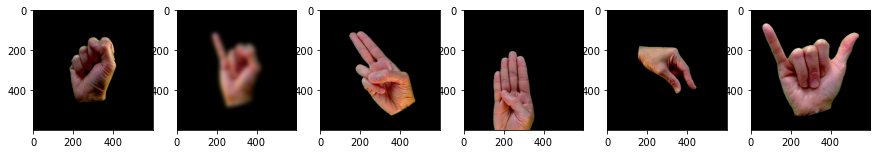

In [ ]:
path = "./FinalImages/"
imgs, labels = loadImages(path)
fig, ax = plt.subplots(1, 6, figsize=(15,10))
ax[0].imshow(imgs[2]) #reshape
ax[1].imshow(imgs[1]) #blur
ax[2].imshow(imgs[3]) #rotate
ax[3].imshow(imgs[13]) #translation
ax[4].imshow(imgs[12]) #flip
ax[5].imshow(imgs[11]) #scale

## Mult_Augments

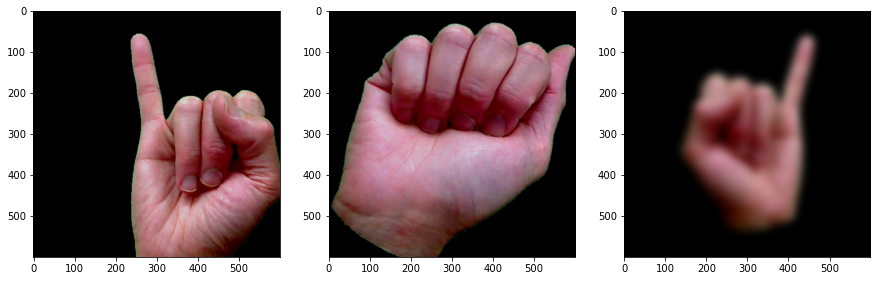

In [ ]:
path = "./Mult_Augments/"
imgs, labels = loadImages(path)
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(imgs[8]) #scale + translate
ax[1].imshow(imgs[18]) #scale + rotate
ax[2].imshow(imgs[6]) #blur + flip

# Models and Evaluation

## Experimental Setup

#### How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?

&nbsp;&nbsp;&nbsp;&nbsp; This is a classification task, hence we evaluated our various classification methods using accuracy on a held-out testing dataset. This is fairly standard for classification tasks, as we want to observe how our trained models perform when given “new” data. Additionally, we evaluated our models on two datasets: normal images and images with multiple augmentations applied. This was to see how our models generalized to “real-world data,” which can be represented by various transformations (rotation, blur, etc.) on the original hand signs.


#### What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

&nbsp;&nbsp;&nbsp;&nbsp; We used cross-entropy loss to train our models. Cross-entropy loss measures the performance of a classification model whose output is a probability value between 0 and 1. We did not try any other loss functions, since cross entropy loss is the standard for image classification problems, as it determines labels based on probability.


#### How did you split your data into train and test sets? Why?

&nbsp;&nbsp;&nbsp;&nbsp; We utilized an 80:10:10 train-dev-test split. We simply wanted a large portion of the data to be given for training the model, and believed that the 10:10 dev-test split (each which was at least 65 images) would be enough to evaluate model accuracy.
Note that when testing on the multiple augmentation images, we did not split the data, as we did not want to train our models on these images, as these represented the “real-world images.”


The loss function was Cross Entropy Loss, where we used the function

    torch.nn.CrossEntropyLoss()

in our training model.

Our evaluation metric was accuracy, which was calculated simply

$$\frac{\# Correct Images}{\# Total Images}$$


The code for loss and accuracy can be found here, in the SimpleCNN.ipynb, SimpleCNN-Features.ipynb, FiveConvLayerCNN.ipynb, and FiveConvLayerCNN-Features.ipynb files:
https://github.com/swadhwa5/MLFinalProject.git

## Baselines 

#### What baselines did you compare against? Why are these reasonable?

&nbsp;&nbsp;&nbsp;&nbsp; In our literature search, we found a paper “Deep Convolutional Networks for Gesture Recognition in American Sign Language,” Bheda and Radpour, 2017. The researchers in this study generated the labeled dataset of 25 images of 5 people signing the ASL alphabet. Hence, we would be able to directly compare the results of our models with their published results. In the paper, the researchers were able to generate a model with an 82.5% accuracy. Another baseline for comparison is random choice, which for this dataset would be 1/26, or 3.85% accuracy. 

#### Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?

The methods in the  “Deep Convolutional Networks for Gesture Recognition in American Sign Language” paper were as follows: 
1. <u>Preprocessing</u>: background subtraction to reduce noise from changes in light
2. <u>Data augmentation</u>: rotate 20 degrees, translate 20%, horizontal flip (to simulate left and right signing) all increased accuracy 
3. <u>Network architecture</u>: 3 groups of 2 convolutional layers followed by a max-pool layer and a dropout layer, and two groups of fully connected layer followed by a dropout layer and one final output​ ​layer.

These methods did fairly well, with a prediction accuracy of 82.5% on the alphabet dataset. 


## Methods

#### What methods did you choose? Why did you choose them?

For our model, we decided to implement a feedforward convolutional neural network with several 2-dimensional convolutional layers and several fully-connected layers to classify the hand signs. This is because CNNs are known to perform very well on image tasks. Specifically, we utilized some popular image-processing CNN models, LeNet, and AlexNet as bases for the models we developed.


#### How did you train these methods, and how did you evaluate them? Why?

These models were trained with an 80:10:10 train:dev:test split on a single 650 dataset of ASL hand signs. Based on this dataset, we added both/either data augmentations and engineered features (hand-to-back ratio and convexity) to develop the four different training instances for our models as follows:
1. normal images
2. normal images and data augmented images
3. normal images, added features (hand-to-back ratio and convexity)
4. normal images, data augmented images, added features (hand-to-back ratio and convexity)

We trained our models based on these different inputs and compared which model would be most effective.


#### Which methods were easy/difficult to implement and train? Why?

It was very easy to train the simple convolutional neural network on the original dataset, as not only did this CNN require an input of 32x32x3 images, but also only had two convolutional layers, resulting in a fast training time. However, the five-layer CNN was much more demanding in terms of computational power, as it required much larger and inputs of 227x227x3, and also had more layers to apply the backpropagation algorithm in order to update the parameters.

In terms of the datasets, the smaller dataset (non-augmented images) was also much easier to train compared to the larger dataset with augmented images. This is simply because having less inputs took the model a shorter period of time to train on.


#### For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

For the *simple convolutional neural network with two convolutional layers*, we evaluated the learning rate (LR) hyperparameter and found that a <u> LR of 0.001</u> to be optimal. Our hyperparameter search showed that a LR that was too large would have suboptimal convergence, and an LR that was too small would get stuck and be unable to decrease training loss at any reasonable rate.

For the *five convolutional neural network with five convolutional layers*, we evaluated the (LR) hyperparameter and found that a <u>LR of 0.0001 </u> to be optimal. Our hyperparameter search showed that a LR similar to the previous would often not result in increased developmental accuracy (and not decrease the training loss), depending on its random initialization. By decreasing the learning rate, we were able to train the model to have higher accuracy.

The function to train the model was as follows:

In [2]:
# Train the model parameters
def train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer, model, num_images, n=20):

  epochs = []
  train_losses = []
  dev_accuracies = []
  for epoch in range(n):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    train_acc, train_loss = approx_train_acc_and_loss(model, train_data, train_labels)
    dev_acc, dev_loss = dev_acc_and_loss(model, dev_data, dev_labels)
    epochs.append(epoch)
    train_losses.append(train_loss)
    dev_accuracies.append(dev_acc)
    step_metrics = {
            'step': epoch, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }
    if epoch % 2 == 0:
      print(f"On step {epoch}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")



  print('Finished Training')
  return epochs, train_losses, dev_accuracies

This function was based on that provided in HW3. The actual implementation can be found here, in the SimpleCNN.ipynb, SimpleCNN-Features.ipynb, FiveConvLayerCNN.ipynb, and FiveConvLayerCNN-Features.ipynb files:
https://github.com/swadhwa5/MLFinalProject.git

In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

An example (taken from the SimpleCNN.ipynb notebook) of the training loss and developmental accuracy is as follows:

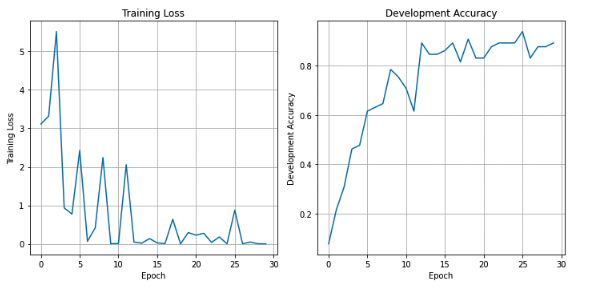

An example (taken from the SimpleCNN-Features.ipynb notebook) of the training loss and developmental accuracy is as follows:

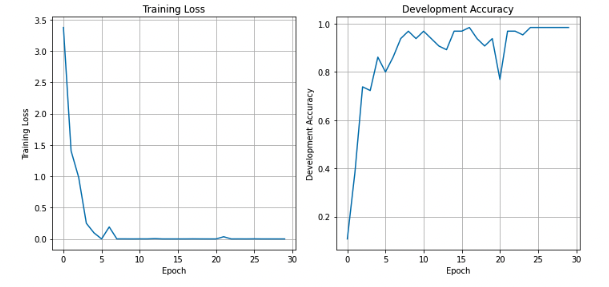

An example (taken from the FiveConvLayerCNN.ipynb notebook) of the training loss and developmental accuracy is as follows:

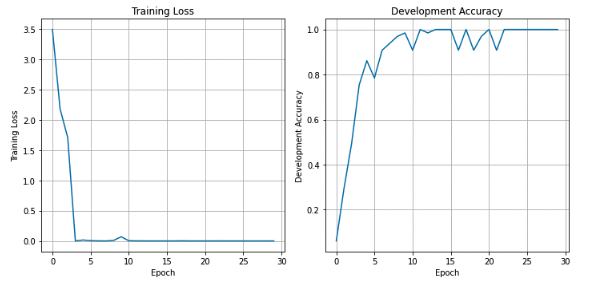

The final example (taken from the FiveConvLayerCNN-Features.ipynb notebook) of the training loss and developmental accuracy is as follows:

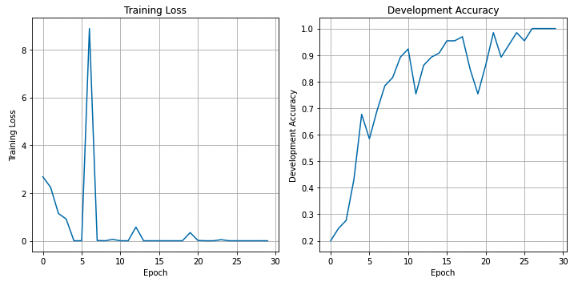

We performed this visualization for each of our models, all of which can be found in the respective model notebooks. I.e., in the SimpleCNN.ipynb, SimpleCNN-Features.ipynb, FiveConvLayerCNN.ipynb, and FiveConvLayerCNN-Features.ipynb files:
https://github.com/swadhwa5/MLFinalProject.git

## Results

#### Show tables comparing your methods to the baselines.

<u> Models trained on the original dataset (handgesturesdataset_part1)</u>

Testing Dataset | Simple CNN | Simple CNN <br/>w/ features | 5 Layer CNN | 5 Layer CNN <br/> w/features
----------------------------------------------|---|----|----|----|
Testing acc. on<br/>handgesturesdataset_part1 |90%|100%|100%|100%|
Testing acc. on<br/> Mult_Augments            |21%|38% |15% |32% |

<u> Models trained on the augmented dataset (FinalImages)</u>

Testing Dataset | Simple CNN | Simple CNN <br/>w/ features | 5 Layer CNN | 5 Layer CNN <br/> w/features
----------------------------------------------|---|----|----|----|
Testing acc. on<br/>handgesturesdataset_part1 |87%|49% |95% |98% |
Testing acc. on<br/> Mult_Augments            |54%|96% |78% |99% |

#### What about these results surprised you? Why?

One result that surprised us was the high testing accuracy when evaluating our trained models on the held-out testing dataset from handgesturesdataset_part1. This suggests our model performed extremely well. However, we also realize that our held-out testing dataset was limited in size (~65 images), so future works should explore testing this model on a larger dataset.

Another result that surprised us was that the simple CNN with features had a much lower accuracy than that without the features when trained on the augmented dataset. We thought that adding additional engineered-features specific to the images would result in higher accuracy, as this was another dimension to classify the images.

The difference between the simple CNN and the 5 layer CNN were expected, as the latter had higher accuracy (likely due to the higher resolution of the input images and the greater number of layers).

Additionally, comparing each model between the same structure but trained on augmented data, we also see an expected result: those trained on the augmented dataset had better generalizability to the “Mult_Augments” dataset.


#### Did your models over- or under-fit? How can you tell? What did you do to address these issues?

The overall goal of our classification task was to determine how models trained on the provided dataset performed both on held-out images from the original dataset, as well as how the models performed on novel, multiple-augmentation images of hand signs.

In the simple convolutional network, the original model trained on the original dataset without augmentations performed very well on held-out testing data. However, when exposed to new data with multiple augmentations, the model performed very poorly. Although we added regularization to the model via dropout layers (which improves generalizability and has higher bias), the model performed poorly when given data outside of its training images. In this sense, the model was overfitting. We were able to increase the accuracy on the multiple-augmentation dataset by applying various single augmentations to the training data, but this still resulted in a model with only 54% compared to the original 21% accuracy, and therefore likely still overfit the training data.

In the five-layer convolutional network, we observed a similar pattern. Despite a high developmental and testing accuracy on images from the original dataset, the models had only a 15% accuracy on the multiple-data augmented dataset. Adding the single augmentations to the training data, we were able to increase this to 78% accuracy. 

When we added the features, there also is a concern that our model overfits. In both models, we achieve 100% accuracy on the dev set with only the original held out testing data. Adding the augmentations revealed low accuracies leading to more suspicion of overfitting. However, our models also achieve very high accuracy on the validation set as well, which indicates that possibly we are not overfitting, and instead our original dataset is simply not very difficult for our models to classify.

We added dropout layers and data augmentation to decrease the effect of overfitting for our models, which resulted in increased accuracy when evaluating the model on the “Mult_Augments” dataset.


#### What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

The evaluation of the trained models tells us that the data itself is very well organized, and each hand sign is different enough to differentiate, as determined by the high test accuracy for the models trained on only normal images. However, this dataset may not be representative of how hand signs may appear in the real world. The models performed worse (about 20% worse) on the multiple-augmentation dataset, which suggests that the models may not be ideal for implementation in a real-world setting to determine various hand signs, as their performance accuracy is likely to be much lower compared to the accuracy determined on the held-out testing data.

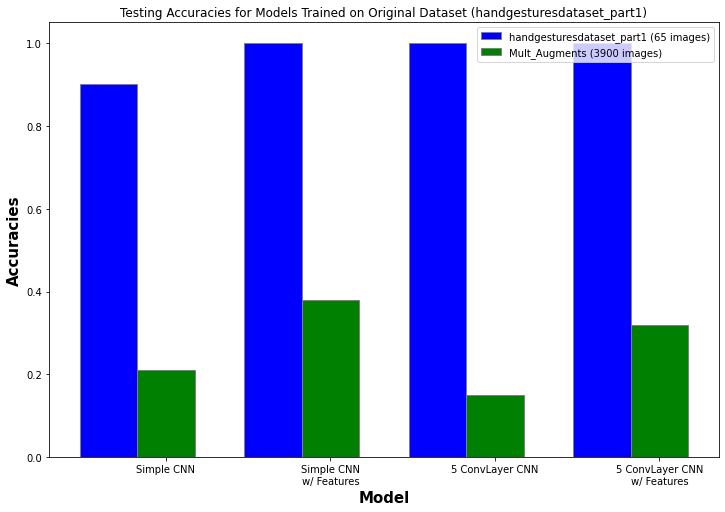

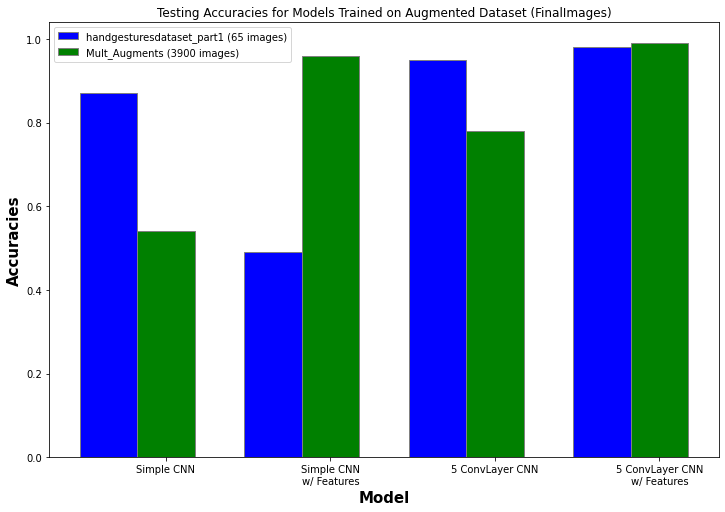

In [22]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

import numpy as np
import matplotlib.pyplot as plt

model_names = ["Simple CNN", "Simple CNN" "\n" "w/ Features", "5 ConvLayer CNN", "5 ConvLayer CNN" "\n" "w/ Features"]

barWidth = 0.35

##################### Trained on Original Dataset ###################
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
acc_orig = [.90,1,1,1]
acc_aug = [.21,.38,.15,.32]
 
# Set position of bar on X axis
br1 = np.arange(len(acc_orig))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, acc_orig, color ='b', width = barWidth,
        edgecolor ='grey', label='handgesturesdataset_part1 (65 images)')
plt.bar(br2, acc_aug, color ='g', width = barWidth,
        edgecolor ='grey', label='Mult_Augments (3900 images)')
 
# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracies', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc_orig))],
        model_names)

# Additional
plt.title("Testing Accuracies for Models Trained on Original Dataset (handgesturesdataset_part1)")
plt.legend()

##################### Trained on Augmented Dataset ###################
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
acc_orig = [.87,.49,.95,.98]
acc_aug = [.54,.96,.78,.99]
 
# Set position of bar on X axis
br1 = np.arange(len(acc_orig))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, acc_orig, color ='b', width = barWidth,
        edgecolor ='grey', label='handgesturesdataset_part1 (65 images)')
plt.bar(br2, acc_aug, color ='g', width = barWidth,
        edgecolor ='grey', label='Mult_Augments (3900 images)')
 
# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracies', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc_orig))],
        model_names)

# Additional
plt.title("Testing Accuracies for Models Trained on Augmented Dataset (FinalImages)")
plt.legend()

##  What do these plots show about over- or under-fitting?

These plots show that several of the models trained on the original dataset were likely overfitting to the data, as they achieved high accuracy when tested on the original data (blue), but when given novel data, they generally performed worse (green). 

For the 5 ConvLayer CNN w/ features, however, it is likely the data was not underfit or overfit when trained on the for the multiple augmentation data, as the accuracy when exposed to multiple augmentation data was similar if not better compared to the testing accuracy on the original data.

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

#### What concepts from lecture/breakout were most relevant to your project? How so?

Some concepts that were most relevant to our project were

1. <u>Classification</u>: In particular, the evaluation method of accuracy and optimization using gradient descent.
2. <u>Neural Networks</u>: creating multi-layered models, using cross-entropy error as a loss function
3. <u>Deep Learning</u>: creating levels of abstraction for image-processing tasks using a model with hidden layers and pooling for summarizing image data. Also using stochastic gradient descent for optimization. Also, the efficacy of dropout layers in preventing overfitting. 
4. <u>FATE</u>: We started by defining our task of creating an image 4.classifier. We then recognized that the dataset is limited in skin color. There was no bias in labeling. In the future, we would test on more real-world hand images and would not deploy until it was verified in a variety of instances. 
5. <u>Practical ML</u>: This lecture helped us verify our pipeline for building a robust model. Through this lecture we learnt that it is important to analyze the dataset you’re working with and to take the test data seriously, i.e. to not use that for training purposes unless debugging. The lecture also mentioned how it is important to set a threshold for that accuracy you wish to achieve and only put in the effort to make new models if the threshold is not met. Since we were able to achieve a high accuracy with LeNet and AlexNet, we did not spend time on implementing many more models.


#### What aspects of your project did you find most surprising?

We found it surprising how adding additional features such as convexity and hand-to-back could result in such a large difference in model performance. This intersection between standard CNN techniques and feature-engineering has large implications in the real-world, especially in pre-processing for prediction.

#### What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?

Through this project, we learned how important it is to know the scope and be aware of the dataset being used for training and testing the models. It is only after we started looking at other datasets and images of ASL hand signs that we realized that it is not enough to make sure our model classifies standard hand signs with a black background well. Hence we decided to add multiple augmentations to our images and trained and tested our model on those images in different scenarios. 

We also learnt that basic models like LeNet are able to perform decently well on image data and hence it’s reasonable to start with simpler models instead of jumping straight to more complex models. 


#### What was the most helpful feedback you received during your presentation? Why?

The most helpful feedback we received during our presentation was from our TA Guangui, who recommended that we use the Adam optimizer instead of SGD. We found that Adam was more effective as an optimizer since it is like SGD but uses an adaptive learning rate.
Also, his feedback that we should consider using features that are more than one float value so that it would have a bigger effect was helpful. Instead of only using the convexity ratio, we added the coordinates of the convex hull and alphashape in addition.


#### If you had two more weeks to work on this project, what would you do next? Why?

If we had two more weeks to work on this project, we would improve the use-case of our model by including a larger dataset of real-world ASL symbols and words as well. Additionally, we could attempt to convert our model into recognizing letters when given an image of an entire person, rather than just a hand. 